In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

import h5py
from astropy.io import ascii
from halotools.mock_observables import return_xyz_formatted_array, delta_sigma

from scipy.interpolate import interp1d
from scipy.special import erfinv

# #---------------------------------------------------------------------------#
from colossus.halo import mass_adv
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')

In [2]:
h_hsc = 0.7
h_tng = 0.6774
h_mdpl2 = 0.6777

z_mdpl2 = 0.36

## box size 

In [3]:
# Massive black 2: Lbox = 100 h^-1 Mpc
# TNG100: Lbox = 75 h^-1 Mpc

Lbox = 75.0   # 75/h
period = np.array([Lbox,Lbox,Lbox])

# This is in Mpc/h comoving
rp_bins = np.logspace(-1.2,1.3,20) #error if using 1.5 because Lbox is 75 and not 100
# rp_bins = np.logspace(-1,1.25,12)# to better match HSC bins
# rp_bins = np.logspace(-1.022,1.277,12) # to even better match HSC bins
print rp_bins

[ 0.06309573  0.08542381  0.11565326  0.1565802   0.2119902   0.28700849
  0.38857395  0.52608102  0.71224856  0.96429636  1.30553787  1.76753662
  2.39302573  3.23986054  4.38637001  5.93860187  8.04013161 10.88534267
 14.73740616 19.95262315]


## particle positions

Benedikt's output: https://bdiemer.bitbucket.io/hydrotools/output_boxptl.html

In [4]:
# particle_data_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/particles/boxptl_tng100-2_099.hdf5'
#particle_data_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/particles/boxptl_tng100_099_20m.hdf5'

particle_data_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/particles/boxptl_tng100_072_20m.hdf5'


In [5]:
f = h5py.File(particle_data_file, 'r')

dm_coords = np.array(f['ptldm_Coordinates'])
dm_particle_mass = np.array(f['config'].attrs['dm_ptl_mass'])

gas_coords = np.array(f['ptlgas_Coordinates'])
gas_particle_masses = np.array(f['ptlgas_Masses'])

star_coords = np.array(f['ptlstr_Coordinates'])
star_particle_masses = np.array(f['ptlstr_Masses'])

z_tng = f['config'].attrs['snap_z']
n_downsampled_particles = f['config'].attrs['ptlgas_nmax']
f.close()

print "Redshift: ", z_tng
print n_downsampled_particles, ' particles'


Redshift:  0.4
20000000  particles


In [6]:
max(dm_coords[:,0]) ##kpc?

74999.99916048232

In [8]:
def format_coordinates_for_halotools(coords):
    # These are in units of kpc(???), put into Mpc
    x=coords[:,0]/1000.0
    y=coords[:,1]/1000.0
    z=coords[:,2]/1000.0
    
    pos = return_xyz_formatted_array(x, y, z)
    
    return pos

dmpos = format_coordinates_for_halotools(dm_coords)
gaspos = format_coordinates_for_halotools(gas_coords)
starpos = format_coordinates_for_halotools(star_coords)

### number of particles 

In [9]:
#illustris-1: 1820^3 DM particles
#illustris-2: 910^3 DM particles

#initially N_DM = N_gas, but gas particles can evolve into stars
# at z=0 N_total_gas ~ N_total_DM, and that stars are ~2.5% of that number (Benedikt's measurement from a lower resolution run)
# Benedikt sent numbers on Slack: n1 + n2*2^32
# in the future, particle numbers will be included in the output attributes

n_total_particles_dm = 1820**3
n_total_particles_gas = 1221956572 + (2**32)
n_total_particles_stars = 386470173

dm_downsampling_factor = n_total_particles_dm/n_downsampled_particles
gas_downsampling_factor = n_total_particles_gas/n_downsampled_particles
stars_downsampling_factor = n_total_particles_stars/n_downsampled_particles

print(dm_downsampling_factor, gas_downsampling_factor, stars_downsampling_factor)

(301, 275, 19)


## galaxy positions 

In [10]:
# Read in the Galaxy File
tng_highres_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2_highres.hdf5'

# #new catalog on Hyades (complete catalog)
# tng_highres_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/particles/galaxies_tng100_099_cat.hdf5'

f = h5py.File(tng_highres_file, 'r')
cat_sh_mstar = np.log10(np.array(f['catsh_SubhaloMassType'][:, 4]))
central = np.array(f['catgrp_is_primary'])
gal_coords = np.array(f['catsh_SubhaloPos'])[(cat_sh_mstar>11.2) & (central == 1)]
tng_m_200c = np.array(f['catgrp_Group_M_Crit200'])[(cat_sh_mstar>11.2) & (central == 1)]
z_tng = f['config'].attrs['snap_z']


f.close()


In [11]:
#convert to Mvir
tng_m_vir, tng_r_vir, tng_c_vir = mass_adv.changeMassDefinitionCModel(tng_m_200c, z_tng, '200c', 'vir',
                                                                      profile='nfw', c_model='diemer19')
log_tng_m_vir = np.log10(tng_m_vir)


#stack masses and coordinates into single array
gal_array = np.stack((log_tng_m_vir, gal_coords[:,0],gal_coords[:,1],gal_coords[:,2]), axis=1)

In [12]:
galpos = format_coordinates_for_halotools(gal_coords)
len(galpos)

235

## weak lensing

In [13]:
output_files_location = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/particles/'

In [14]:
def calculate_ds(galpos, particle_pos, particle_mass, downsampling_factor, rp_bins, Lbox,
                 output_file_name):
    r, ds = delta_sigma(galpos, particle_pos, particle_mass, downsampling_factor, rp_bins, Lbox)
    
    #convert to correct physical units
    ds = ds/1e12 # convert units pc^-2 --> Mpc^-2
    ds = ds*h_tng*((1+z_tng**2)) #convert from comoving h-inverse to physical real-h
    r = r / float(h_tng*(1+z_tng)) #convert from comoving h-inverse to physical real-h
    
    
    array = np.array(zip(r,ds), dtype=[('r(Mpc)','f8'),('DS','f8')])
    np.save(output_file_name, array)
    
    return r, ds

def weak_lensing(galpos, 
                 dmpos, gaspos, starpos, 
                 dm_particle_mass, gas_particle_masses, star_particle_masses,
                 dm_downsampling_factor, gas_downsampling_factor, stars_downsampling_factor, 
                 rp_bins, Lbox, output_files_location, mass_bin):
    
    #calculate delta sigma for each component
    #DM
    r, dm_ds = calculate_ds(galpos, dmpos, dm_particle_mass, dm_downsampling_factor, rp_bins, Lbox,
                          output_files_location+'dm_ds{0}.npy'.format(mass_bin))
    print 'dm_ds'#, dm_ds
    
    #gas
    r, gas_ds = calculate_ds(galpos, gaspos, gas_particle_masses, gas_downsampling_factor, rp_bins, Lbox,
                          output_files_location+'gas_ds{0}.npy'.format(mass_bin))
    print 'gas_ds'#, dm_ds
    
    #stars
    r, stars_ds = calculate_ds(galpos, starpos, star_particle_masses, stars_downsampling_factor, rp_bins, Lbox,
                          output_files_location+'stars_ds{0}.npy'.format(mass_bin))
    print 'stars_ds'#, dm_ds
    
    
    #sum all components together
    total_ds = dm_ds + gas_ds + stars_ds
    total_ds_array = np.array(zip(r,total_ds), dtype=[('r(Mpc)','f8'),('DS','f8')])
    np.save(output_files_location+'total_ds{0}.npy'.format(mass_bin), total_ds_array)
    print 'total_ds'#, total_ds
    
    return r, dm_ds, gas_ds, stars_ds, total_ds
    
    

## compare to HSC

three bins from Song in Mvir (random forest) 

In [15]:
hsc_files_loc = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/weak_lensing/'
old_hsc_arrays = [np.load(hsc_files_loc+'asap_hsc_mvir_predict_1805_bin{0}.npz'.format(i)) for i in [1,2,3]]
hsc_arrays_old = [np.load(hsc_files_loc+'asap_hsc_mvir_predict_1906_bin{0}.npz'.format(i)) for i in [1,2,3]]

mass_bins_strings = ['13.00','13.42','13.83','14.25']
hsc_arrays = [np.load(hsc_files_loc+'hsc_s16a_dsig_logmvir_{0}_{1}.npy'.format(mass_bins_strings[i],mass_bins_strings[i+1])) for i in range(3)]


In [23]:
hsc_r_bins = hsc_arrays[0]['r_mpc']

# Check bins of halo mass (same as plot in paper)
the only thing changing are the galaxy positions


In [16]:
mass_bins = np.linspace(13.0,14.25,4)

In [17]:
def get_galaxies_in_bins(gal_array, mass_bins):
    '''
    gets galaxies in each mass bin of mass_bins. assumes mass is first column of gal_array. returns array where 
    each element corresponds to the array of galaxies in that mass bin. 
    '''
    n_bins = len(mass_bins) - 1
    
    gals_in_bins=[]
    
    masses = gal_array[:,0]
    
    for bin in range(n_bins):
        lower = mass_bins[bin]
        upper = mass_bins[bin+1]
        
        gals = gal_array[(masses>lower) & (masses<upper)]
        
        gals_in_bins.append(gals)
        
    return gals_in_bins

In [18]:
galaxies_in_bin = get_galaxies_in_bins(gal_array, mass_bins)

## jackknife errors

In [19]:
def weak_lensing_function(galaxy_positions):
    return weak_lensing(galaxy_positions, 
                                         dmpos, gaspos, starpos, 
                                         dm_particle_mass, gas_particle_masses, star_particle_masses,
                                         dm_downsampling_factor, gas_downsampling_factor, stars_downsampling_factor, 
                                         rp_bins, Lbox, output_files_location)[-1]

In [20]:
def single_plot(r, dm_ds, gas_ds, stars_ds, total_ds, l_mass, u_mass, ax, jack_err, total_only=False):
    #make plot
    
#     fig = plt.figure(figsize=(15, 10))
    if not total_only:
        ax.loglog(r, dm_ds, linestyle='--', linewidth=4.0, c='k', alpha=1, zorder=8, label='DM')
        ax.loglog(r, gas_ds, linestyle='-.', linewidth=4.0, c='b', alpha=1, zorder=8, label='Gas')
        ax.loglog(r, stars_ds, linestyle=':', linewidth=4.0, c='r', alpha=1, zorder=8, label='Stars')
        total_color = 'g'
    else:
        total_color = '#1f77b4'

    #plot total
    ax.loglog(r, total_ds, linestyle='--', linewidth=5.0, c=total_color, alpha=1, zorder=8, label=r'$\mathrm{TNG100}$')
    ax.fill_between(r, total_ds+jack_err, total_ds-jack_err, alpha=0.5 )

    ######################################################################################################################
    # plot details
    ######################################################################################################################

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_ylim([7*10**-2, 4*10**2])

    #text label
    ax.text(0.05, 0.1, r'${0}<\log \left(\mathrm{{M_{{vir}}}}\right)<{1}$'.format(round(l_mass,2), round(u_mass,2)),
            size=34, transform=ax.transAxes) #transform to axis coords rather than data coordinates

    #axis labels and vertical lines
    ax.set_xlabel(r'$\mathrm{R \ [Mpc]}$', fontsize=40)
    ax.set_ylabel(r'$\Delta\Sigma \ [(M_{\odot})/\mathrm{pc}^2]$', fontsize=40)
#     ax.legend(fontsize=30)
    

In [28]:
jack_errs = np.load(output_files_location+'TNG_jackknife_errors.npy')

## errors from MDPL2 from Enia 

In [24]:
MDPL2_array = np.load('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/other/errors_felipe2.npz') 
# in dropbox its called jn_errors_felipe.npz

SMDPL_array1 = np.load('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/other/SMDPL/smdpl_dsig_logmvir_13.00_13.42.npy') 
SMDPL_array2 = np.load('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/other/SMDPL/smdpl_dsig_logmvir_13.42_13.83.npy') 
SMDPL_array3 = np.load('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/other/SMDPL/smdpl_dsig_logmvir_13.83_14.25.npy') 

#interpolate
SMDPL_array = [interp1d(smdpl_array['r_mpc'],
                        smdpl_array['dsigma'])(hsc_r_bins) for smdpl_array in [SMDPL_array1,SMDPL_array2,SMDPL_array3]]


In [25]:
#convert everything from comoving h-inverse to physical real-h units
MDPL_array_converted_units = MDPL2_array
MDPL_array_converted_units_R = MDPL2_array['R']/float(h_mdpl2*(1+z_mdpl2))

MDPL_array_converted_units_mean=[]
MDPL_array_converted_units_err=[]

for i in [0,1,2]:
    MDPL_array_converted_units_mean.append(MDPL2_array['mean'][i]*h_mdpl2*((1+z_mdpl2**2)))
    MDPL_array_converted_units_err.append(MDPL2_array['err'][i]*h_mdpl2*((1+z_mdpl2**2)))


In [26]:
# r =annular_area_weighted_midpoints(rp_bins)

mdpl2_errs = [interp1d(MDPL_array_converted_units_R, MDPL_array_converted_units_err[i],
                       fill_value="extrapolate")(hsc_r_bins) for i in [0,1,2]]

82  galaxies
Plotting...
35  galaxies
Plotting...
13  galaxies
Plotting...


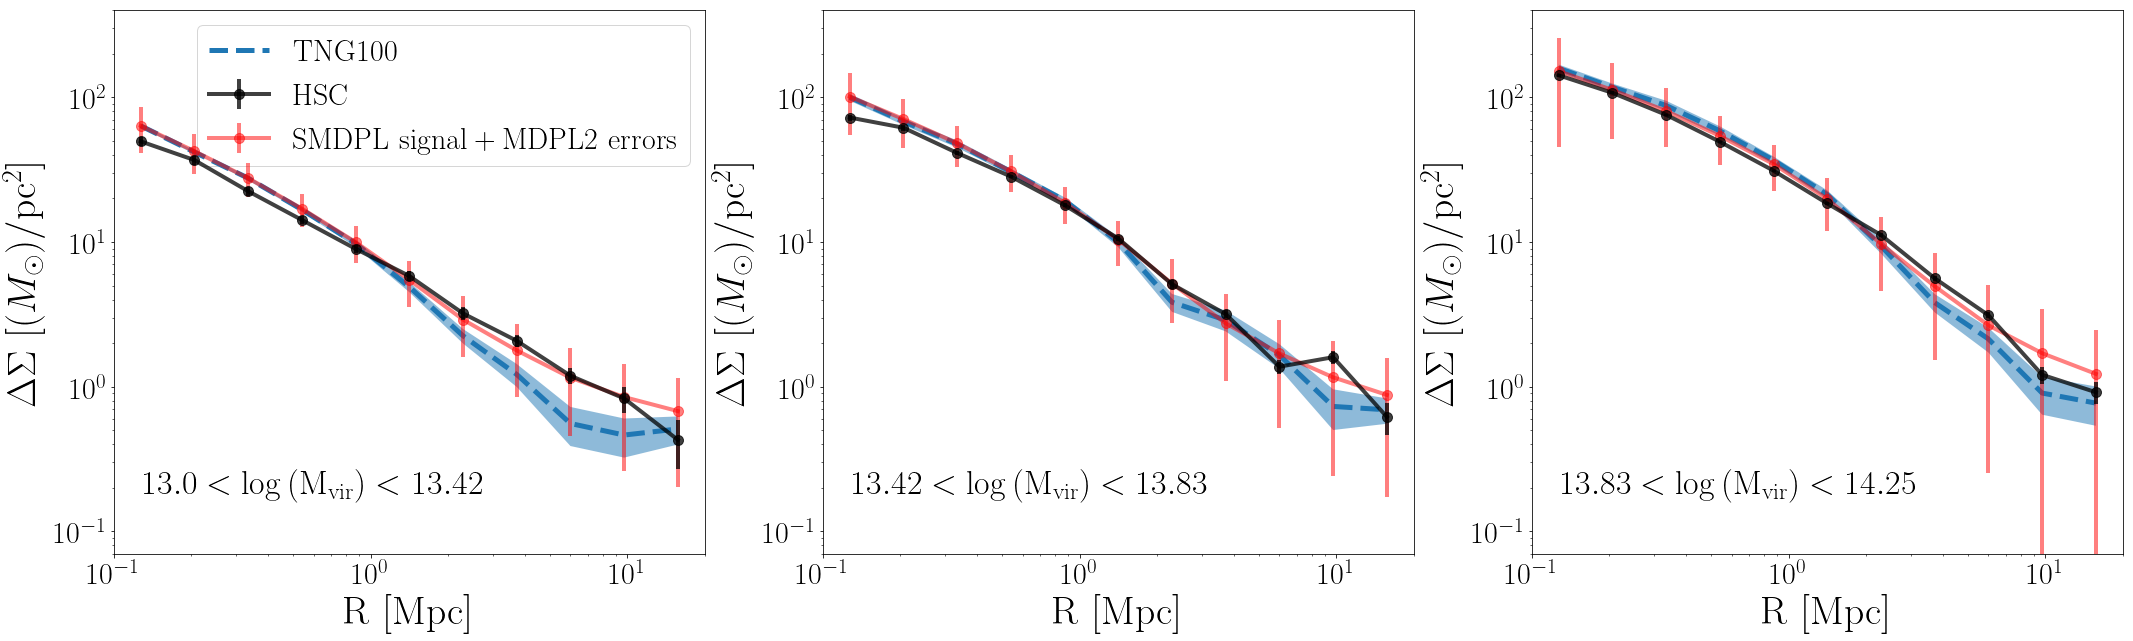

In [34]:
fig = plt.figure(figsize=(12*3, 10))
axes = [plt.subplot(1,3,i) for i in [1,2,3]]

for i, gals in enumerate(galaxies_in_bin):
    
    #plot TNG
    gal_coords = gals[:,1:]
    galpos = format_coordinates_for_halotools(gal_coords)
    
    print len(galpos), ' galaxies'
    
    try:
        total_ds = np.load(output_files_location+'total_ds{0}.npy'.format(i))['DS']
        dm_ds = np.load(output_files_location+'dm_ds{0}.npy'.format(i))['DS']
        gas_ds = np.load(output_files_location+'gas_ds{0}.npy'.format(i))['DS']
        stars_ds = np.load(output_files_location+'stars_ds{0}.npy'.format(i))['DS']
        r = np.load(output_files_location+'stars_ds{0}.npy'.format(i))['r(Mpc)']
    except:
    
        r, dm_ds, gas_ds, stars_ds, total_ds = weak_lensing(galpos, 
                                             dmpos, gaspos, starpos, 
                                             dm_particle_mass, gas_particle_masses, star_particle_masses,
                                             dm_downsampling_factor, gas_downsampling_factor, stars_downsampling_factor, 
                                             rp_bins, Lbox, output_files_location, mass_bin=i)

    #interpolate to hsc_r_bins
    dm_ds = interp1d(r, dm_ds)(hsc_r_bins)
    gas_ds = interp1d(r, gas_ds)(hsc_r_bins)
    stars_ds = interp1d(r, stars_ds)(hsc_r_bins)
    total_ds = interp1d(r, total_ds)(hsc_r_bins)
    
    #jackknife standard errors
    print('Plotting...')
#     jack_err = jackknife_stats(galpos,weak_lensing_function)[2]
    jack_err = interp1d(r, jack_errs['err'][i])(hsc_r_bins)
#     jack_err = mdpl2_errs[i]
    
    single_plot(hsc_r_bins, dm_ds, gas_ds, stars_ds, total_ds, mass_bins[i], mass_bins[i+1], axes[i], jack_err, total_only=True)
    
    axes[i].loglog()
    #plot HSC
    axes[i].errorbar(hsc_arrays[i]['r_mpc'], hsc_arrays[i]['dsigma_lr'], hsc_arrays[0]['dsigma_err_jk'], c='k', markersize=10, 
                 marker='o', linewidth=4.0, alpha=0.75, label= r'$\mathrm{HSC}$', zorder=10)
    #plot SMDPL
    axes[i].errorbar(hsc_arrays[i]['r_mpc'], SMDPL_array[i], mdpl2_errs[i], c='r', markersize=10, 
                 marker='o', linewidth=4.0, alpha=0.5, label= r'$\mathrm{SMDPL \ signal + MDPL2 \ errors}$', zorder=9)
    
axes[0].legend(loc='upper right',fontsize=30)

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/weak_lensing_with_SMDPL+MDPL2_errors.pdf',
            dpi=100, format='pdf', bbox_inches='tight')    
plt.show()

## export HSC arrays for GitHub 

In [ ]:
entries_to_keep = ['r_mpc', 'dsigma_lr','dsigma_err_jk']

output_dir = '/Users/fardila/Documents/GitHub/HSC_vs_hydro-paper/data/HSC/delta_sigma/'
np.save(output_dir + 'hsc_s16a_dsigma_logmvir_13.00_13.42.npy',
        hsc_arrays[0][entries_to_keep])
np.save(output_dir + 'hsc_s16a_dsigma_logmvir_13.42_13.83.npy',
        hsc_arrays[1][entries_to_keep])
np.save(output_dir + 'hsc_s16a_dsigma_logmvir_13.83_14.25.npy',
        hsc_arrays[2][entries_to_keep])